# Em's VCF pipeline  
A simple step-by-step workbook to take reads, align to a reference genome and generate per-sample vcfs or gvcf files.  

## 0. Environment Setup
All required software is inside the conda environment:  
**Bondlab_phylo_env**

You should see this kernel selected in the top‑right of your Jupyter window.  
If not, run the following on the FARM login node:

1. module load conda  
2. conda activate /group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env  
3. python -m ipykernel install --user --name Bondlab_phylo_env --display-name "Python [conda env:Bondlab_phylo_env]"

## 0.1 CPU Check
The next cell checks how many CPUs are available in your OnDemand session or SLURM allocation.  
If the number looks too small for your job, restart your Jupyter session with more CPUs.

In [1]:
# check cpus available and set global THREADS
import os
THREADS = int(os.getenv("SLURM_CPUS_PER_TASK"))
print("CPUs available:", THREADS)

CPUs available: 64


### 0.1 Python library imports  

In [2]:
# Standard library
import os
import sys
import glob
import gzip
import json
import math
import random
import re
import shutil
import subprocess
from pathlib import Path
from datetime import datetime

# UI and display
from ipywidgets import Dropdown, Button, VBox, HTML, Output
from IPython.display import display, clear_output, HTML, Markdown

# Data + plotting
import pandas as pd
import matplotlib.pyplot as plt

## 1. Input Data

This pipeline requires two inputs:
1. **A reference genome** (FASTA)
2. **A directory of Illumina paired‑end reads**, one directory per project or batch

Spider genomes are typically large (human‑sized or larger), and sequencing facilities often produce **many files**, usually:

- `sampleX_R1.fastq.gz`
- `sampleX_R2.fastq.gz`

Please name your read files **something meaningful** (e.g. `Genus_species_sampleID_R1.fastq.gz`).  
Long names are fine — meaningful names help track samples through the pipeline.

### 1.1 Preparing Your Input Files
Before running the pipeline, place your reference genome and read files in the expected locations on the FARM storage.  
**1. Reference Genome**  
If it is not alreeady there, copy your reference FASTA file into:  
/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/references/  

**2. Sequencing Reads**  
Create a new directory for your reads inside:  
_Ems_vcf_pipeline/data/read_directories/  

To save storage, **soft‑link** your FASTQ files into this directory:  
ln -s /path/to/your/reads/*.fastq.gz new_directory/  

**3. Select Your Inputs Below**  
The next cell will let you choose:  
- the reference FASTA   
- the directory containing your read files   

Once selected, continue with the pipeline.

In [3]:
import os
from pathlib import Path
from ipywidgets import Dropdown, Button, VBox, Output
from IPython.display import display, clear_output, Markdown

out = Output()

PROJECT_ROOT = "/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline"
refs_dir     = f"{PROJECT_ROOT}/data/references"
reads_root   = f"{PROJECT_ROOT}/data/read_directories"

# --- Helper functions ---
def list_refs():
    return sorted([f for f in os.listdir(refs_dir)
                   if f.lower().endswith((".fa",".fasta",".fna"))])

def list_read_dirs():
    return sorted([d for d in os.listdir(reads_root)
                   if os.path.isdir(os.path.join(reads_root, d))])

def pair_fastqs(dirpath):
    """Return dict sample -> {R1,R2} and list of unpaired files."""
    files = sorted(Path(dirpath).glob("*.fastq*"))
    pairs = {}
    unpaired = []

    tmp = {}
    for f in files:
        b = f.name
        if "_R1" in b:
            stem = b.split("_R1")[0]
            tmp.setdefault(stem, {})["R1"] = f
        elif "_R2" in b:
            stem = b.split("_R2")[0]
            tmp.setdefault(stem, {})["R2"] = f
        else:
            unpaired.append(f)

    for stem, rec in tmp.items():
        if "R1" in rec and "R2" in rec:
            pairs[stem] = rec
        else:
            unpaired.extend(rec.values())

    return pairs, unpaired

# --- Widgets ---
ref_dd  = Dropdown(options=list_refs(), description="Reference:", layout={'width':'70%'})
reads_dd= Dropdown(options=list_read_dirs(), description="Reads:", layout={'width':'70%'})
btn     = Button(description="Select", button_style="success")

display(VBox([ref_dd, reads_dd, btn, out]))

def on_click(_):
    clear_output(wait=True)
    display(VBox([ref_dd, reads_dd, btn]))

    ref = Path(refs_dir)/ref_dd.value
    rd  = Path(reads_root)/reads_dd.value

    pairs, unpaired = pair_fastqs(rd)

    # Create run directory
    run = Path(PROJECT_ROOT)/"results"/reads_dd.value
    ref_work = run/"reference"
    ref_work.mkdir(parents=True, exist_ok=True)

    ref_link = ref_work/ref.name
    if ref_link.exists() or ref_link.is_symlink():
        ref_link.unlink()
    ref_link.symlink_to(ref)

   # Save to globals
    global REFERENCE, READS_DIR, PAIRS, UNPAIRED, RUN_DIR, REF_FASTA
    REFERENCE = str(ref_link)
    READS_DIR = str(rd)
    PAIRS     = pairs
    UNPAIRED  = unpaired
    RUN_DIR   = str(run)
    REF_FASTA = REFERENCE  # convenience alias used later

    # Summary
    with out:
        print("✓ Reference:", ref.name)
        print("✓ Read set:", reads_dd.value)
        print("✓ Samples detected:", len(pairs))
        if unpaired:
            print("⚠ Unpaired files:", len(unpaired))
        print("Run directory:", run)

btn.on_click(on_click)


## 2. Pipeline preparation: 
### 2.1 Index reference files (if necessary):  
This takes a few minutes to run.

In [4]:
## 2. Pipeline preparation: Index reference files (if necessary)

# ---- Require globals from selection cell ----
if "REFERENCE" not in globals() or "RUN_DIR" not in globals():
    raise RuntimeError("REFERENCE and RUN_DIR not set. Run the selection cell first.")

REF_FASTA = Path(REFERENCE)
fasta_path = str(REF_FASTA)

# Expected index files
fai_path = fasta_path + ".fai"
bwa_mem2_files = [fasta_path + ".0123", fasta_path + ".pac"]

def run(cmd):
    print("  $", " ".join(cmd))
    subprocess.run(cmd, check=True)

print("Reference FASTA:", fasta_path)

# ---- (1) samtools faidx ----
print("\n[1/2] samtools faidx")
if not os.path.exists(fai_path):
    print("  Creating .fai index")
    run(["samtools", "faidx", fasta_path])
else:
    print("  .fai index exists, skipping.")

# ---- (2) bwa-mem2 index ----
print("\n[2/2] bwa-mem2 index")
if not all(os.path.exists(p) for p in bwa_mem2_files):
    print("  Building bwa-mem2 index")
    run(["bwa-mem2", "index", fasta_path])
else:
    print("  bwa-mem2 index exists, skipping.")

print("\nDone indexing.")
print("Generated/validated:")
print("  -", fai_path)
print("  - bwa-mem2 index files alongside the FASTA")

Reference FASTA: /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa

[1/2] samtools faidx
  Creating .fai index
  $ samtools faidx /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa

[2/2] bwa-mem2 index
  Building bwa-mem2 index
  $ bwa-mem2 index /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa


Looking to launch executable "/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/bin/bwa-mem2.avx2", simd = .avx2
Launching executable "/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/bin/bwa-mem2.avx2"


ref_seq_len = 100000
count = 0, 25219, 50000, 74781, 100000
BWT[3726] = 4
CP_SHIFT = 6, CP_MASK = 63
sizeof CP_OCC = 64
max_occ_ind = 1562

Done indexing.
Generated/validated:
  - /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa.fai
  - bwa-mem2 index files alongside the FASTA


[bwa_index] Pack FASTA... 0.00 sec
* Entering FMI_search
init ticks = 15477480
ref seq len = 100000
binary seq ticks = 7041672
build suffix-array ticks = 40153752
pos: 12501, ref_seq_len__: 12500
build fm-index ticks = 21047808
Total time taken: 0.0482


## 3. Pipeline: QC on raw reads
### 3.1 Runs FastQC on raw R1/R2 reads for each sample.  
If reports already exist, this cell will skip them.  
(Optionally run the next cell to build a MultiQC summary.)

In [5]:
## 3. QC on raw reads (FastQC)
from pathlib import Path
import os, re, subprocess

# ---- Required globals from earlier cells ----
for name in ["RUN_DIR", "PAIRS", "THREADS"]:
    if name not in globals() or globals()[name] in (None, "", {}):
        raise RuntimeError(f"Missing required global: {name}. Run the selection cell first.")

# Make a new global for downstream cells
global QC_RAW_DIR
QC_RAW_DIR = Path(RUN_DIR) / "qc" / "fastqc_raw"
QC_RAW_DIR.mkdir(parents=True, exist_ok=True)

def run(cmd):
    print("  $", " ".join(cmd))
    subprocess.run(cmd, check=True)

def fastqc_report_html(outdir: Path, fq_path: str) -> Path:
    base = Path(fq_path).name
    # Strip .fastq(.gz) or .fq(.gz)
    base = re.sub(r'\.(fastq|fq)(\.gz)?$', '', base, flags=re.IGNORECASE)
    return outdir / f"{base}_fastqc.html"

if not PAIRS:
    print("No paired FASTQs found (PAIRS is empty). Did you select the correct read directory?")
else:
    print(f"Running FastQC on raw reads (threads={THREADS})")

    for sample_id, paths in sorted(PAIRS.items()):
        r1, r2 = str(paths["R1"]), str(paths["R2"])
        print(f"\n[FastQC: raw] {sample_id}")

        # Optional: ensure inputs still exist
        missing = [p for p in (r1, r2) if not os.path.exists(p)]
        if missing:
            print("  ⚠ Skipping — missing file(s):", ", ".join(missing))
            continue

        # Idempotency check: FastQC writes <basename>_fastqc.html (where basename strips .fastq(.gz)/.fq(.gz))
        r1_html = fastqc_report_html(QC_RAW_DIR, r1)
        r2_html = fastqc_report_html(QC_RAW_DIR, r2)

        if r1_html.exists() and r2_html.exists():
            print("  Raw FastQC outputs exist, skipping.")
            continue

        run(["fastqc", "-t", str(THREADS), "-o", str(QC_RAW_DIR), r1, r2])

    print("\nRaw FastQC finished; outputs:")
    print(" ", QC_RAW_DIR)

Running FastQC on raw reads (threads=64)

[FastQC: raw] sample1
  $ fastqc -t 64 -o /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/qc/fastqc_raw /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/read_directories/tiny_test_readset/sample1_R1.fastq.gz /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/read_directories/tiny_test_readset/sample1_R2.fastq.gz
application/gzip
application/gzip


Started analysis of sample1_R1.fastq.gz
Approx 30% complete for sample1_R1.fastq.gz
Approx 65% complete for sample1_R1.fastq.gz
Approx 100% complete for sample1_R1.fastq.gz


Analysis complete for sample1_R1.fastq.gz


Started analysis of sample1_R2.fastq.gz
Approx 30% complete for sample1_R2.fastq.gz
Approx 65% complete for sample1_R2.fastq.gz
Approx 100% complete for sample1_R2.fastq.gz


Analysis complete for sample1_R2.fastq.gz

[FastQC: raw] sample2
  $ fastqc -t 64 -o /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/qc/fastqc_raw /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/read_directories/tiny_test_readset/sample2_R1.fastq.gz /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/read_directories/tiny_test_readset/sample2_R2.fastq.gz
application/gzip
application/gzip


Started analysis of sample2_R1.fastq.gz
Approx 30% complete for sample2_R1.fastq.gz
Approx 65% complete for sample2_R1.fastq.gz
Approx 100% complete for sample2_R1.fastq.gz


Analysis complete for sample2_R1.fastq.gz


Started analysis of sample2_R2.fastq.gz
Approx 35% complete for sample2_R2.fastq.gz
Approx 65% complete for sample2_R2.fastq.gz
Approx 100% complete for sample2_R2.fastq.gz


Analysis complete for sample2_R2.fastq.gz

Raw FastQC finished; outputs:
  /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/qc/fastqc_raw


### 3.2 MultiQC
After this next MultiQC cell is run it is best to downlaod the html file to your laptop and open in a regular browser with javascript to see the charts.

In [6]:
## 3A. (Optional) MultiQC summary of raw FastQC reports
from pathlib import Path
import subprocess

if "QC_RAW_DIR" not in globals():
    raise RuntimeError("QC_RAW_DIR is not set. Run the FastQC cell first.")

print("Building MultiQC report for raw FastQC…")
subprocess.run(["multiqc", str(QC_RAW_DIR), "-o", str(QC_RAW_DIR)], check=True)
print("Done. See:", Path(QC_RAW_DIR) / "multiqc_report.html")

Building MultiQC report for raw FastQC…



/// ]8;id=980797;https://multiqc.info\MultiQC]8;;\ v1.33

       file_search | Search path: /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/qc/fastqc_raw


        searching | ████████████████████████████████████████ 100% 8/8                                                   .zip

            fastqc | Found 4 reports
     write_results | Data        : /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/qc/fastqc_raw/multiqc_data
     write_results | Report      : /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/qc/fastqc_raw/multiqc_report.html
           multiqc | MultiQC complete



Done. See: /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/qc/fastqc_raw/multiqc_report.html


## 4. Trimming adapters with cutadapt

In [7]:
## 4. Trimming with cutadapt
from pathlib import Path
import os, re, subprocess

# Globals needed: RUN_DIR, PAIRS, THREADS, PROJECT_ROOT
for name in ["RUN_DIR", "PAIRS", "THREADS", "PROJECT_ROOT"]:
    if name not in globals() or not globals()[name]:
        raise RuntimeError(f"Missing global: {name}")

TRIM_DIR = Path(RUN_DIR) / "trimmed"
TRIM_DIR.mkdir(parents=True, exist_ok=True)
ADAPTERS = Path(PROJECT_ROOT) / "data" / "adapters" / "adapters.fasta"

def run(cmd):
    print("  $", " ".join(cmd))
    subprocess.run(cmd, check=True)

def print_adapters_file_missing_error_message():
    print("""
adapters file missing, please make this fasta file called adapters.fasta in /data/adapters/        
>i5
AGATCGGAAGAGCGTCGTGTAGGGAAAGAGTGTCCTATTGAGTGTAGATCTCGGTGGTCGCCGTATCATT
>i7
GATCGGAAGAGCACACGTCTGAACTCCAGTCACCGTGCTGGATCTCGTATGCCGTCTTCTGCTTG
    """)

print(f"Trimming with cutadapt (threads={THREADS})")

first_r1 = next(iter(PAIRS.values()))["R1"]
gz = str(first_r1).lower().endswith(".gz")   # FIX: Convert PosixPath → str before .lower()
EXT = ".fastq.gz" if gz else ".fastq"

for sample, paths in sorted(PAIRS.items()):
    r1 = str(paths["R1"])
    r2 = str(paths["R2"])
    out1 = TRIM_DIR / f"{sample}.R1.trimmed{EXT}"
    out2 = TRIM_DIR / f"{sample}.R2.trimmed{EXT}"

    print(f"\n[Trim] {sample}")
    if out1.exists() and out2.exists():
        print("  Trimmed outputs exist, skipping.")
        continue

    cmd = ["cutadapt", "-j", str(THREADS), "-q", "15,15", "-m", "36", "-o", str(out1), "-p", str(out2)]
    if ADAPTERS.exists():
        cmd += ["-g", f"file:{ADAPTERS}", "-G", f"file:{ADAPTERS}", "-a", f"file:{ADAPTERS}", "-A", f"file:{ADAPTERS}"]
    else:
        print_adapters_file_missing_error_message()
    cmd += [r1, r2]
    run(cmd)

print("\nTrimmed outputs in:", TRIM_DIR)

Trimming with cutadapt (threads=64)

[Trim] sample1
  $ cutadapt -j 64 -q 15,15 -m 36 -o /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/trimmed/sample1.R1.trimmed.fastq.gz -p /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/trimmed/sample1.R2.trimmed.fastq.gz -g file:/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/adapters/adapters.fasta -G file:/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/adapters/adapters.fasta -a file:/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/adapters/adapters.fasta -A file:/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/adapters/adapters.fasta /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/read_directories/tiny_test_readset/sample1_R1.fastq.gz /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/read_direct

In [8]:
# 3. Align reads to the reference
# Align with BWA-MEM
#bwa mem -t 8 reference.fasta sample_R1.trimmed.fastq.gz sample_R2.trimmed.fastq.gz > sample.sam

## 5. Align | Sort, Mark Duplicates, Index and Cleanup  
It will take some time to create the bams as they are streaming to the sort, so you won't see the intermediate files (to save space and time). This is obviously a slow bit doing the alignment work - give it some cores.    

In [9]:
## Align → Sort (streamed) → MarkDuplicates + index → Cleanup (with read groups)
from pathlib import Path
import subprocess

# Ensure globals are Paths
RUN_DIR   = Path(RUN_DIR)
TRIM_DIR  = Path(TRIM_DIR)
REF_FASTA = Path(REF_FASTA)

ALN_DIR = RUN_DIR / "alignments"
ALN_DIR.mkdir(parents=True, exist_ok=True)

# THREADS is a global you set when launching the Jupyter env
THREADS = int(THREADS)

def run(cmd, msg, use_shell=False):
    print(f"  → {msg}")
    if use_shell:
        subprocess.run(cmd, shell=True, check=True, executable="/bin/bash")
    else:
        subprocess.run(cmd, check=True)

def trimmed_read(sample, tag):
    gz = TRIM_DIR / f"{sample}.{tag}.trimmed.fastq.gz"
    fq = TRIM_DIR / f"{sample}.{tag}.trimmed.fastq"
    return gz if gz.exists() else fq

# If you have READ_SET_NAME as a global, use it for LB; else default to sample name.
READ_SET_NAME = globals().get("READ_SET_NAME", None)

for sample, _ in sorted(PAIRS.items()):
    print(f"\n=== {sample} ===")
    r1 = trimmed_read(sample, "R1")
    r2 = trimmed_read(sample, "R2")

    bam_sorted = ALN_DIR / f"{sample}.sorted.bam"
    bam_dedup  = ALN_DIR / f"{sample}.dedup.bam"
    bai_dedup  = ALN_DIR / f"{sample}.dedup.bam.bai"

    # Read group (minimal but valid)
    LB = READ_SET_NAME if READ_SET_NAME else sample
    rg = f'@RG\\tID:{sample}\\tSM:{sample}\\tPL:ILLUMINA\\tLB:{LB}\\tPU:{sample}'

    # 1) Align → Sort (streamed; no intermediate SAM/BAM)
    if not bam_sorted.exists():
        cmd = (
            f'set -o pipefail; '
            f'bwa-mem2 mem -t {THREADS} -R "{rg}" "{REF_FASTA}" "{r1}" "{r2}" '
            f'| samtools sort -@ {THREADS} -o "{bam_sorted}"'
        )
        run(cmd, "Aligning + sorting (streamed)", use_shell=True)
    else:
        print("  sorted BAM exists – skipping")

    # 2) Mark duplicates + index
    if not bam_dedup.exists():
        run([
            "gatk", "MarkDuplicates",
            "-I", str(bam_sorted),
            "-O", str(bam_dedup),
            "-M", str(ALN_DIR / f"{sample}.metrics.txt"),
            "--CREATE_INDEX", "true"
        ], "Marking duplicates + indexing")
    else:
        print("  deduplicated BAM exists – skipping")

    # 3) Cleanup (keep only final dedup BAM + .bai + metrics)
    if bam_sorted.exists() and bam_dedup.exists() and bai_dedup.exists():
        try:
            bam_sorted.unlink()
            print("  cleaned up temporary sorted BAM")
        except Exception:
            pass

print("\nDone! Final BAMs (dedup + index) and metrics are in:", ALN_DIR)


=== sample1 ===
  → Aligning + sorting (streamed)


Looking to launch executable "/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/bin/bwa-mem2.avx2", simd = .avx2
Launching executable "/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/bin/bwa-mem2.avx2"
-----------------------------
Executing in AVX2 mode!!
-----------------------------
* SA compression enabled with xfactor: 8
* Ref file: /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa
* Entering FMI_search
* Index file found. Loading index from /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa.bwt.2bit.64
* Reference seq len for bi-index = 100001
* sentinel-index: 3726
* Count:
0,	1
1,	25220
2,	50001
3,	74782
4,	100001

* Reading other elements of the index from files /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa
* Index prefix: /group/jbondgrp2/ste

  → Marking duplicates + indexing


Using GATK jar /group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar MarkDuplicates -I /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample1.sorted.bam -O /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample1.dedup.bam -M /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample1.metrics.txt --CREATE_INDEX true
18:33:08.890 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/share

Tool returned:
0

=== sample2 ===
  → Aligning + sorting (streamed)


Looking to launch executable "/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/bin/bwa-mem2.avx2", simd = .avx2
Launching executable "/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/bin/bwa-mem2.avx2"
-----------------------------
Executing in AVX2 mode!!
-----------------------------
* SA compression enabled with xfactor: 8
* Ref file: /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa
* Entering FMI_search
* Index file found. Loading index from /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa.bwt.2bit.64
* Reference seq len for bi-index = 100001
* sentinel-index: 3726
* Count:
0,	1
1,	25220
2,	50001
3,	74782
4,	100001

* Reading other elements of the index from files /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa
* Index prefix: /group/jbondgrp2/ste

  → Marking duplicates + indexing


Using GATK jar /group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/share/gatk4-4.6.2.0-0/gatk-package-4.6.2.0-local.jar MarkDuplicates -I /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample2.sorted.bam -O /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample2.dedup.bam -M /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample2.metrics.txt --CREATE_INDEX true
18:33:21.996 INFO  NativeLibraryLoader - Loading libgkl_compression.so from jar:file:/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/share

Tool returned:
0

Done! Final BAMs (dedup + index) and metrics are in: /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments


## 6. Variant calling (VCF generation)
### 6.1 Variant calling with FreeBayes (creates a cohort.freebayes.vcf.gz file)

In [10]:
## FreeBayes per-scaffold (robust pool, longest-first, with logs + progress bar)
from pathlib import Path
import subprocess, os, time, math
from datetime import timedelta

# Optional: nice Jupyter progress bar; will gracefully fallback if not present
use_widgets = False
try:
    from IPython.display import display
    import ipywidgets as widgets
    use_widgets = True
except Exception:
    use_widgets = False

RUN_DIR   = Path(RUN_DIR)
ALN_DIR   = RUN_DIR / "alignments"
VAR_DIR   = RUN_DIR / "variants" / "freebayes"
TMP_DIR   = VAR_DIR / "_tmp_chunks"
for d in (VAR_DIR, TMP_DIR):
    d.mkdir(parents=True, exist_ok=True)

REF_FASTA = Path(REF_FASTA)
THREADS   = int(THREADS)

# Gather BAMs
bams = sorted(ALN_DIR.glob("*.dedup.bam"))
if not bams:
    raise RuntimeError("No deduplicated BAMs found")

# Ensure indexes
if not Path(str(REF_FASTA) + ".fai").exists():
    subprocess.run(["samtools", "faidx", str(REF_FASTA)], check=True)
for b in bams:
    if not Path(str(b) + ".bai").exists():
        subprocess.run(["samtools", "index", str(b)], check=True)

# Read contigs + lengths, sort longest-first (reduces long-tail)
contigs = []
with open(str(REF_FASTA) + ".fai") as f:
    for line in f:
        name, length, *_ = line.strip().split("\t")
        contigs.append((name, int(length)))
contigs.sort(key=lambda x: x[1], reverse=True)

# Helper to derive output chunk path
def out_paths_for(ctg: str):
    out_vcf = TMP_DIR / f"{ctg}.vcf.gz"
    log     = TMP_DIR / f"{ctg}.log"
    return out_vcf, log

# Compute how many chunks are already done (idempotent re-runs)
already_done = sum(1 for ctg, _L in contigs if out_paths_for(ctg)[0].exists())
total_chunks = len(contigs) - already_done

# Concurrency: safe for Jupyter; set to THREADS for full saturation
jobs = max(1, THREADS // 2)
print(f"Running {len(contigs)} scaffolds with up to {jobs} concurrent workers...")
if already_done:
    print(f"Resuming: {already_done} scaffolds already completed from a previous run.")

def chunk_cmd(ctg):
    out_vcf, log = out_paths_for(ctg)
    # Skip if completed
    if out_vcf.exists():
        return None
    cmd = (
        f'freebayes -f "{REF_FASTA}" '
        f'--region "{ctg}" --min-mapping-quality 20 --min-base-quality 20 --use-best-n-alleles 4 '
        + " ".join(f'"{b}"' for b in bams)
        + f' 2> "{log}" | bgzip -c > "{out_vcf}"'
    )
    return cmd

# Prepare queue of commands
queue = [chunk_cmd(ctg) for ctg, _L in contigs]
queue = [c for c in queue if c]  # drop None for already-done
procs = {}  # pid -> (Popen, cmd)

# Progress UI
start_ts = time.time()
completed_last = already_done

if use_widgets:
    pbar = widgets.IntProgress(
      value=already_done, min=0, max=already_done + total_chunks, step=1, description='UCE call:', bar_style=''
    )
    status = widgets.HTML()
    box = widgets.VBox([pbar, status])
    display(box)
else:
    print(f"[Progress] {already_done}/{already_done + total_chunks} completed | active=0 | queue={len(queue)} | ETA=--:--:--")

def eta_text(done, total, elapsed):
    if done <= 0 or elapsed < 1e-6:
        return "--:--:--"
    rate = done / elapsed  # chunks per second
    remain = max(0, total - done)
    secs = int(remain / rate) if rate > 0 else 0
    return str(timedelta(seconds=secs))

def update_progress():
    # Count completed by checking files (robust to any external completion)
    done_now = sum(1 for ctg, _L in contigs if out_paths_for(ctg)[0].exists())
    active = len(procs)
    qrem   = len(queue)
    elapsed = time.time() - start_ts
    eta = eta_text(done_now - already_done, total_chunks, elapsed)
    if use_widgets:
        pbar.max = already_done + total_chunks
        pbar.value = done_now
        pbar.description = f"{done_now}/{already_done + total_chunks}"
        status.value = f"<code>active={active} | queue={qrem} | ETA={eta}</code>"
    else:
        print(f"\r[Progress] {done_now}/{already_done + total_chunks} completed | active={active} | queue={qrem} | ETA={eta}    ", end='', flush=True)

def launch():
    while queue and len(procs) < jobs:
        cmd = queue.pop(0)
        p = subprocess.Popen(cmd, shell=True, executable="/bin/bash")
        procs[p.pid] = (p, cmd)

# Prime the pool and show initial progress
launch()
update_progress()

# Keep refilling until all work done
while procs or queue:
    time.sleep(0.5)  # slightly faster UI refresh
    finished = []
    for pid, (p, cmd) in list(procs.items()):
        ret = p.poll()
        if ret is not None:
            finished.append(pid)
            if ret != 0:
                print(f"\n[WARN] Chunk exited {ret}: {cmd}")
    for pid in finished:
        procs.pop(pid, None)
    launch()
    update_progress()

# Ensure final progress line ends cleanly in text mode
if not use_widgets:
    print()

# Concatenate all chunks (in fasta order)
chunk_vcfs = [str(TMP_DIR / f"{ctg}.vcf.gz") for ctg, _L in contigs if (TMP_DIR / f"{ctg}.vcf.gz").exists()]
if not chunk_vcfs:
    raise RuntimeError("No chunk VCFs were produced; check logs in _tmp_chunks/")

vcf_gz = VAR_DIR / "cohort.freebayes.vcf.gz"
subprocess.run(["bcftools", "concat", "-Oz", "-o", str(vcf_gz)] + chunk_vcfs, check=True)
subprocess.run(["bcftools", "index", "-t", str(vcf_gz)], check=True)

if use_widgets:
    status.value = f"<b>Done.</b> Output: <code>{vcf_gz}</code>"
else:
    print("Done. Output:", vcf_gz)


Running 2 scaffolds with up to 32 concurrent workers...


Checking the headers and starting positions of 2 files
[W::bcf_hdr_check_sanity] GQ should be declared as Type=Integer
Concatenating /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/variants/freebayes/_tmp_chunks/ctgA.vcf.gz	0.003085 seconds
Concatenating /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/variants/freebayes/_tmp_chunks/ctgB.vcf.gz	0.002662 seconds


### 6.2 Split cohort VCF into individual per-sample VCFs

In [11]:
## Split FreeBayes cohort VCF into per-sample VCFs (parallel + progress)

from pathlib import Path
import subprocess, concurrent.futures, os, time
from datetime import timedelta

# Optional: Jupyter progress bar (fallback to text if widgets not available)
use_widgets = False
try:
    from IPython.display import display
    import ipywidgets as widgets
    use_widgets = True
except Exception:
    use_widgets = False

# --- Paths / globals from earlier cells ---
RUN_DIR  = Path(RUN_DIR)  # e.g., results/<read_set>
VAR_DIR  = RUN_DIR / "variants" / "freebayes"
COHORT_VCF = VAR_DIR / "cohort.freebayes.vcf.gz"
PER_SAMPLE_DIR = VAR_DIR / "per-sample"
PER_SAMPLE_DIR.mkdir(parents=True, exist_ok=True)

# --- Sanity checks ---
if not COHORT_VCF.exists():
    raise RuntimeError(f"Cohort VCF not found: {COHORT_VCF}. Run the FreeBayes calling cell first.")

tbi = Path(str(COHORT_VCF) + ".tbi")
if not tbi.exists():
    subprocess.run(["bcftools", "index", "-t", str(COHORT_VCF)], check=True)

# --- Get sample IDs from the cohort VCF header ---
res = subprocess.run(["bcftools", "query", "-l", str(COHORT_VCF)],
                     check=True, capture_output=True, text=True)
samples_all = [s for s in res.stdout.strip().splitlines() if s]

if not samples_all:
    raise RuntimeError("No samples found in cohort VCF header.")

# --- Build worklist (skip samples that already have both files) ---
work = []
skipped = 0
for s in samples_all:
    out_vcf = PER_SAMPLE_DIR / f"{s}.vcf.gz"
    out_tbi = Path(str(out_vcf) + ".tbi")
    if out_vcf.exists() and out_tbi.exists():
        skipped += 1
    else:
        work.append((s, out_vcf))

total = len(work)
print(f"Per-sample export: {len(samples_all)} sample(s) total "
      f"(to do={total}, skipped={skipped})")

if total == 0:
    print("Nothing to do.")
else:
    # --- Parallelism (safe default): use ~1/4 of THREADS, at least 2, up to #samples ---
    THREADS = int(THREADS)  # from your session
    default_workers = max(2, THREADS // 4)
    workers = min(default_workers, total)
    # Allow override via a global if you want: JOBS_PER_SAMPLE_SPLIT
    workers = int(globals().get("JOBS_PER_SAMPLE_SPLIT", workers))
    print(f"Running {workers} parallel worker(s)...")

    # Progress UI
    start_ts = time.time()
    done = 0
    if use_widgets:
        pbar = widgets.IntProgress(value=0, min=0, max=total, description='Split:')
        status = widgets.HTML()
        box = widgets.VBox([pbar, status])
        display(box)
    else:
        print(f"[Progress] 0/{total} | ETA=--:--:--", end='', flush=True)

    def eta_text(done, total, elapsed):
        if done <= 0 or elapsed <= 0:
            return "--:--:--"
        rate = done / elapsed  # samples per sec
        remain = total - done
        secs = int(remain / rate) if rate > 0 else 0
        return str(timedelta(seconds=secs))

    def update_progress():
        #nonlocal done
        elapsed = time.time() - start_ts
        eta = eta_text(done, total, elapsed)
        if use_widgets:
            pbar.value = done
            pbar.description = f"{done}/{total}"
            status.value = f"<code>workers={workers} | ETA={eta}</code>"
        else:
            print(f"\r[Progress] {done}/{total} | ETA={eta}    ", end='', flush=True)

    # Worker function
    def extract_one(sample: str, out_vcf: Path):
        # 1) bcftools view -s <sample> -Oz -o <out>
        subprocess.run(["bcftools", "view", "-s", sample, "-Oz",
                        "-o", str(out_vcf), str(COHORT_VCF)],
                       check=True)
        # 2) tabix index
        subprocess.run(["bcftools", "index", "-t", str(out_vcf)], check=True)
        return sample

    # Launch pool
    failures = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as ex:
        future_map = {ex.submit(extract_one, s, out): s for s, out in work}
        for fut in concurrent.futures.as_completed(future_map):
            s = future_map[fut]
            try:
                fut.result()
            except Exception as e:
                failures.append((s, str(e)))
                print(f"\n[WARN] {s}: failed → {e}")
            finally:
                done += 1
                update_progress()

    # Finalize progress line
    if not use_widgets:
        print()

    # Summary
    written = total - len(failures)
    print(f"\nDone. Per-sample VCFs in: {PER_SAMPLE_DIR}")
    print(f"Summary: written={written}, skipped={skipped}, failed={len(failures)}, total={len(samples_all)}")
    if failures:
        print("Failed samples:")
        for s, msg in failures:
            print(f"  - {s}: {msg}")


Per-sample export: 2 sample(s) total (to do=2, skipped=0)
Running 2 parallel worker(s)...



Done. Per-sample VCFs in: /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/variants/freebayes/per-sample
Summary: written=2, skipped=0, failed=0, total=2


[W::bcf_hdr_check_sanity] GQ should be declared as Type=Integer
[W::bcf_hdr_check_sanity] GQ should be declared as Type=Integer


## 7. Run Summary stats  
### 7.1 Final summary cell  
Note this was really written fro the previous complicated pipeline, that had some merit but was too complicated. Hence it is looking for alignemnet stats etc. Perhaps this is better now, and hopefully fast enough to run overnight or something for a spdier lab genome set.

In [12]:
### Final Summary Cell
print("Stated summary report cell...")
import os, re, json, shutil, subprocess
from pathlib import Path
from datetime import datetime
from IPython.display import display, Markdown  # <-- for Markdown rendering in Jupyter

# ---------- Inputs from earlier cells ----------
try:
    PROJECT_ROOT
except NameError:
    raise RuntimeError("PROJECT_ROOT not set. Run the selection/setup cells first.")

READS_DIR = Path(READS_DIR) 
PAIRS         = globals().get("PAIRS", {})
REF_FASTA     = globals().get("REF_FASTA", None)

RUN_DIR       = Path(RUN_DIR)
QC_RAW_DIR    = Path(QC_RAW_DIR)  
#QC_TRIM   = Path(QC_TRIM)   # What does it want here
TRIM_DIR  = Path(TRIM_DIR) 
ALN_DIR   = Path(ALN_DIR)
VAR_DIR   = Path(VAR_DIR)
LOGS_DIR  = RUN_DIR / "logs" 
REPORT_MD = RUN_DIR / "run_report.md"

# Expected VCF (adjust name if you used a different filename)
VCF_GZ   = VAR_DIR  / "cohort.freebayes.vcf.gz"
VCF_TBI  = VAR_DIR  / "cohort.freebayes.vcf.gz.tbi"

# ---------- Tool checks ----------
def have_tool(name: str) -> bool:
    return shutil.which(name) is not None

if not have_tool("samtools"):
    raise RuntimeError("samtools not found in PATH.")
if not have_tool("bcftools"):
    raise RuntimeError("bcftools not found in PATH.")

def run_cmd(cmd: list[str]) -> str:
    """Run command and return stdout; raise if non-zero exit."""
    proc = subprocess.run(cmd, capture_output=True, text=True)
    if proc.returncode != 0:
        raise RuntimeError(f"Command failed: {' '.join(cmd)}\n{proc.stderr}")
    return proc.stdout

# ---------- Alignment stats per sample ----------
align_stats = {}
for sample_id in sorted(PAIRS.keys()):
    bam_dedup = ALN_DIR / f"{sample_id}.dedup.bam"
    md_metrics = ALN_DIR / f"{sample_id}.markdup.metrics.txt"
    if not bam_dedup.exists():
        print(f"[WARN] Missing dedup BAM for sample {sample_id}: {bam_dedup}")
        continue
    # samtools flagstat summary
    fs = run_cmd(["samtools", "flagstat", str(bam_dedup)])
    # Parse a few key values
    total = mapped = prop = dups = None
    for line in fs.splitlines():
        if " in total " in line:
            m = re.match(r"(\d+)\s+\+\s+\d+\s+in total", line)
            if m: total = int(m.group(1))
        elif " mapped (" in line:
            m1 = re.match(r"(\d+)\s+\+\s+\d+\s+mapped\s+\(([\d\.]+)%", line)
            if m1:
                mapped = (int(m1.group(1)), float(m1.group(2)))
        elif " properly paired " in line:
            m2 = re.match(r"(\d+)\s+\+\s+\d+\s+properly paired\s+\(([\d\.]+)%", line)
            if m2:
                prop = (int(m2.group(1)), float(m2.group(2)))
        elif " duplicates" in line:
            m3 = re.match(r"(\d+)\s+\+\s+\d+\s+duplicates", line)
            if m3: dups = int(m3.group(1))

    # Parse duplication rate from MarkDuplicates metrics (Picard/GATK)
    dup_rate = None
    if md_metrics.exists():
        txt = Path(md_metrics).read_text(errors="ignore").splitlines()
        header_idx = None
        for i, ln in enumerate(txt):
            if ln.strip().startswith("LIBRARY\t"):
                header_idx = i
                break
        if header_idx is not None and header_idx + 1 < len(txt):
            header = txt[header_idx].split("\t")
            data = txt[header_idx+1].split("\t")
            if "PERCENT_DUPLICATION" in header and len(data) == len(header):
                j = header.index("PERCENT_DUPLICATION")
                try:
                    dup_rate = float(data[j])
                except Exception:
                    pass

    align_stats[sample_id] = {
        "total_reads": total,
        "mapped_reads": mapped[0] if mapped else None,
        "mapped_pct": mapped[1] if mapped else None,
        "proper_pairs": prop[0] if prop else None,
        "proper_pairs_pct": prop[1] if prop else None,
        "dup_reads": dups,
        "dup_rate_metric": dup_rate,  # from MarkDuplicates (0..1)
        "bam": str(bam_dedup),
    }

# ---------- VCF-level stats ----------
vcf_stats = {
    "vcf_path": str(VCF_GZ),
    "indexed": VCF_TBI.exists(),
    "samples": [],
    "n_variants": None,
    "n_snps": None,
    "n_indels": None,
    "ts_tv": None
}

if VCF_GZ.exists():
    # Samples
    vcf_stats["samples"] = run_cmd(["bcftools", "query", "-l", str(VCF_GZ)]).split()
    # bcftools stats
    stats_txt = run_cmd(["bcftools", "stats", str(VCF_GZ)])
    # Parse SN and TSTV lines
    for line in stats_txt.splitlines():
        if line.startswith("SN"):
            parts = line.split("\t")
            if len(parts) >= 4:
                label = parts[2].strip().lower()
                val = parts[3].strip()
                if label == "number of records:":
                    vcf_stats["n_variants"] = int(val)
                elif label == "number of snps:":
                    vcf_stats["n_snps"] = int(val)
                elif label == "number of indels:":
                    vcf_stats["n_indels"] = int(val)
        elif line.startswith("TSTV"):
            parts = line.split("\t")
            # Expect: TSTV  0  ALL  nTransitions  nTransversions  ts/tv
            if len(parts) >= 6 and (parts[2].upper() == "ALL"):
                try:
                    vcf_stats["ts_tv"] = float(parts[5])
                except Exception:
                    pass
else:
    print(f"[WARN] VCF not found: {VCF_GZ}")

# ---------- Disk usage info ----------
def human_bytes(n):
    units = ["B","KB","MB","GB","TB"]
    i = 0
    f = float(n)
    while f >= 1024 and i < len(units)-1:
        f /= 1024; i += 1
    return f"{f:.2f} {units[i]}"

def total_size(path: Path) -> int:
    total = 0
    if not path.exists(): return 0
    for root, _, files in os.walk(path):
        for f in files:
            p = Path(root) / f
            try:
                total += p.stat().st_size
            except Exception:
                pass
    return total

disk = shutil.disk_usage(str(RUN_DIR))
sizes = {
    "trimmed": total_size(TRIM_DIR),
    "alignments": total_size(ALN_DIR),
    "variants": total_size(VAR_DIR),
    "qc_raw": total_size(QC_RAW_DIR),
    # "qc_trim": total_size(QC_TRIM),
}

# ---------- Build Markdown report ----------
lines = []
lines.append(f"# Run Report — {READ_SET_NAME}\n")
lines.append(f"_Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}_\n")
lines.append("## Paths")
lines.append(f"- Project root: `{PROJECT_ROOT}`")
lines.append(f"- Run dir: `{RUN_DIR}`")
if REF_FASTA: lines.append(f"- Reference (run-local): `{REF_FASTA}`")
lines.append("")

lines.append("## Input summary")
lines.append(f"- Samples detected: **{len(PAIRS)}**")
lines.append(f"- Trimmed reads dir: `{TRIM_DIR}`")
lines.append("")

lines.append("## Alignment summary (per sample)")
if align_stats:
    lines.append("| Sample | Total reads | Mapped (%) | Proper pairs (%) | Duplicates | Dup. rate (MarkDup) | BAM |")
    lines.append("|---|---:|---:|---:|---:|---:|---|")
    for sid, st in align_stats.items():
        m_pct = f"{st['mapped_pct']:.2f}%" if st['mapped_pct'] is not None else "NA"
        p_pct = f"{st['proper_pairs_pct']:.2f}%" if st['proper_pairs_pct'] is not None else "NA"
        dup_reads = f"{st['dup_reads']:,}" if st['dup_reads'] is not None else "NA"
        dup_rate = f"{st['dup_rate_metric']*100:.2f}%" if st['dup_rate_metric'] is not None else "NA"
        lines.append(f"| {sid} | {st['total_reads'] or 'NA'} | {m_pct} | {p_pct} | {dup_reads} | {dup_rate} | `{st['bam']}` |")
else:
    lines.append("_No alignment stats found. Did the alignment cell run?_")
lines.append("")

lines.append("## VCF summary")
if VCF_GZ.exists():
    lines.append(f"- VCF: `{VCF_GZ.name}` (indexed: **{'yes' if vcf_stats['indexed'] else 'no'}**)")
    lines.append(f"- Samples in VCF: **{len(vcf_stats['samples'])}**")
    lines.append(f"- Total variants: **{vcf_stats['n_variants'] if vcf_stats['n_variants'] is not None else 'NA'}**")
    lines.append(f"- SNPs: **{vcf_stats['n_snps'] if vcf_stats['n_snps'] is not None else 'NA'}**")
    lines.append(f"- Indels: **{vcf_stats['n_indels'] if vcf_stats['n_indels'] is not None else 'NA'}**")
    lines.append(f"- Ts/Tv: **{vcf_stats['ts_tv'] if vcf_stats['ts_tv'] is not None else 'NA'}**")
else:
    lines.append(f"- VCF not found at `{VCF_GZ}`")
lines.append("")

lines.append("## Disk usage for this run")
lines.append(f"- Run dir free/total: {human_bytes(disk.free)} / {human_bytes(disk.total)}")
for k, v in sizes.items():
    lines.append(f"- {k}: {human_bytes(v)}")
lines.append("")

# Write & render report
REPORT_MD.write_text("\n".join(lines))
display(Markdown(REPORT_MD.read_text()))  # <-- render as Markdown in the notebook

# Also produce a machine-readable manifest (optional)
manifest = {
    "read_set": READ_SET_NAME,
    "run_dir": str(RUN_DIR),
    "reference": str(REF_FASTA) if REF_FASTA else None,
    "samples": sorted(PAIRS.keys()),
    "alignment": align_stats,
    "vcf": vcf_stats,
    "sizes": {k: int(v) for k, v in sizes.items()},
    "generated_at": datetime.now().isoformat()
}
with open(RUN_DIR / "run_manifest.json", "w") as jf:
    json.dump(manifest, jf, indent=2)

# You can also show the "Saved" message as Markdown if you prefer:
display(Markdown(
    f"**Saved:**  \n- `{REPORT_MD}`  \n- `{RUN_DIR / 'run_manifest.json'}`"
))

Stated summary report cell...


# Run Report — None

_Generated: 2026-01-23 18:33:32_

## Paths
- Project root: `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline`
- Run dir: `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset`
- Reference (run-local): `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/reference/tiny_test.fa`

## Input summary
- Samples detected: **2**
- Trimmed reads dir: `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/trimmed`

## Alignment summary (per sample)
| Sample | Total reads | Mapped (%) | Proper pairs (%) | Duplicates | Dup. rate (MarkDup) | BAM |
|---|---:|---:|---:|---:|---:|---|
| sample1 | 5790 | 100.00% | 100.00% | 0 | NA | `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample1.dedup.bam` |
| sample2 | 5804 | 100.00% | 100.00% | 0 | NA | `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/alignments/sample2.dedup.bam` |

## VCF summary
- VCF: `cohort.freebayes.vcf.gz` (indexed: **yes**)
- Samples in VCF: **2**
- Total variants: **5**
- SNPs: **5**
- Indels: **0**
- Ts/Tv: **NA**

## Disk usage for this run
- Run dir free/total: 2.31 TB / 15.00 TB
- trimmed: 467.01 KB
- alignments: 669.53 KB
- variants: 13.62 KB
- qc_raw: 6.92 MB


**Saved:**  
- `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/run_report.md`  
- `/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/results/tiny_test_readset/run_manifest.json`

### 7.2 VCF QC Plots, - I don't know what they mean. 

Running bcftools stats...


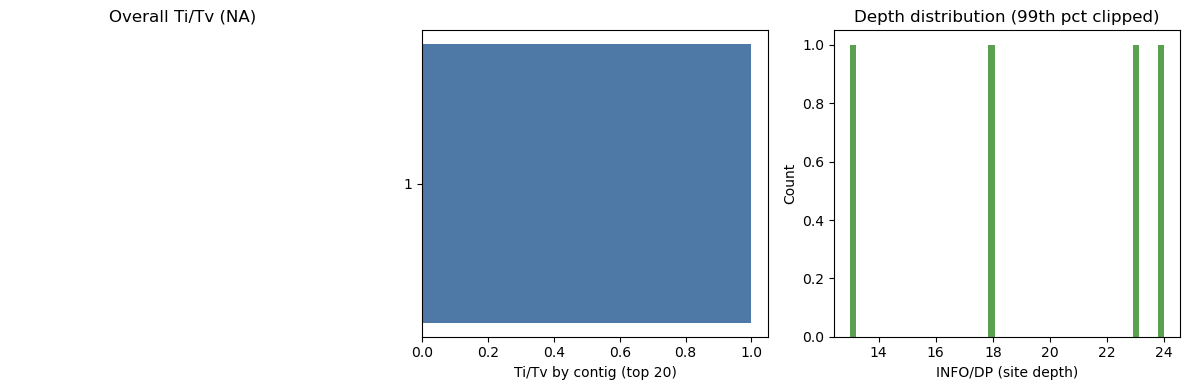

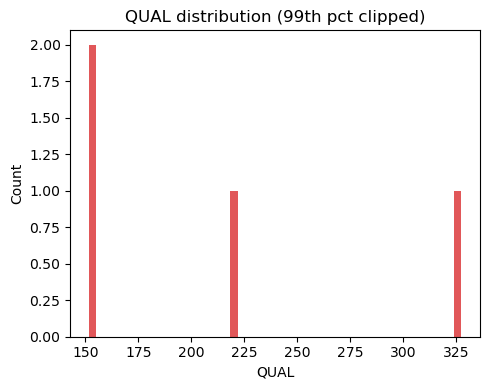

Tip: On chromosome-scale assemblies, evaluate Ti/Tv per chromosome and compare autosomes vs. known/putative sex chromosomes. Low Ti/Tv in specific regions may indicate repeats or low mappability.


In [13]:
# 📈 Quick VCF QC plots: Ti/Tv overall + by contig, DP and QUAL histograms
import subprocess, shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Resolve paths & pick VCF ---
VAR_DIR = Path(VAR_DIR)
vcf_candidates = [
    VAR_DIR / "cohort.freebayes.vcf.gz",
]
vcf = next((v for v in vcf_candidates if v.exists()), None)
if vcf is None:
    raise RuntimeError("No cohort VCF found. Run the variant calling pipeline first.")

# --- Tool sanity check ---
if shutil.which("bcftools") is None:
    raise RuntimeError("bcftools not in PATH; required for bcftools stats/query.")

def run_bcftools_stats_any(vcf_path: Path, ref_fa, out_path: Path):
    """
    Robust bcftools stats:
      A) global -o before subcommand (preferred for some builds)
      B) capture stdout (works everywhere)
    Falls back cleanly; writes out_path on success.
    """
    # Prefer with reference if provided
    with_ref = (ref_fa is not None) and str(ref_fa).strip()

    # Try A: global -o
    try:
        if with_ref:
            cmd = ["bcftools", "-o", str(out_path), "stats", "-F", str(ref_fa), "-s", "-", str(vcf_path)]
        else:
            cmd = ["bcftools", "-o", str(out_path), "stats", "-s", "-", str(vcf_path)]
        r = subprocess.run(cmd, capture_output=True, text=True)
        if r.returncode == 0 and out_path.exists() and out_path.stat().st_size > 0:
            return
    except Exception:
        pass  # fall through

    # Try B: capture stdout (with -F if available)
    if with_ref:
        r = subprocess.run(["bcftools", "stats", "-F", str(ref_fa), "-s", "-", str(vcf_path)],
                           capture_output=True, text=True)
        if r.returncode == 0 and r.stdout:
            out_path.write_text(r.stdout)
            return

    # Final fallback: capture stdout without -F
    r = subprocess.run(["bcftools", "stats", "-s", "-", str(vcf_path)],
                       capture_output=True, text=True)
    if r.returncode == 0 and r.stdout:
        out_path.write_text(r.stdout)
        return

    raise RuntimeError(f"bcftools stats failed.\nSTDERR:\n{r.stderr}")

# --- bcftools stats (cache) ---
stats_path = vcf.with_suffix(".stats.txt")
if not stats_path.exists() or stats_path.stat().st_mtime < vcf.stat().st_mtime:
    print("Running bcftools stats...")
    run_bcftools_stats_any(vcf, REF_FASTA, stats_path)

# --- Parse bcftools stats: SN (summary) and TSTV (per-contig) ---
sn_rows, tstv_rows = [], []
with open(stats_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line or line.startswith("#"):
            continue
        if line.startswith("SN"):
            parts = line.rstrip("\n").split("\t")
            if len(parts) >= 4:
                key = parts[2]
                val_str = parts[3]
                try:
                    val = float(val_str)
                except ValueError:
                    val = val_str
                sn_rows.append((key, val))
        elif line.startswith("TSTV"):
            parts = line.rstrip("\n").split("\t")
            if len(parts) >= 6:
                chrom = parts[2]
                try:
                    ts = float(parts[3])
                except ValueError:
                    ts = np.nan
                try:
                    tv = float(parts[4])
                except ValueError:
                    tv = np.nan
                try:
                    ratio = float(parts[5]) if parts[5] not in ("nan", ".", "NA") else np.nan
                except ValueError:
                    ratio = np.nan
                tstv_rows.append((chrom, ts, tv, ratio))

sn_df = pd.DataFrame(sn_rows, columns=["metric", "value"]) if sn_rows else pd.DataFrame(columns=["metric", "value"])
tstv_df = pd.DataFrame(tstv_rows, columns=["chrom", "ts", "tv", "tstv"]) if tstv_rows else pd.DataFrame(columns=["chrom", "ts", "tv", "tstv"])

# --- Key summary metrics ---
overall_tstv = None
n_snp = None
if not sn_df.empty:
    if (sn_df["metric"] == "TSTV").any():
        try:
            overall_tstv = float(sn_df.loc[sn_df["metric"] == "TSTV", "value"].iloc[0])
        except Exception:
            overall_tstv = None
    if (sn_df["metric"] == "number of SNPs").any():
        try:
            n_snp = int(float(sn_df.loc[sn_df["metric"] == "number of SNPs", "value"].iloc[0]))
        except Exception:
            n_snp = None

# --- INFO/DP and QUAL via bcftools query ---
def _capture_lines(cmd):
    r = subprocess.run(cmd, capture_output=True, text=True)
    return [ln.strip() for ln in r.stdout.splitlines() if ln.strip()]

dp_lines  = _capture_lines(["bcftools", "query", "-f", "%INFO/DP\n", str(vcf)])
qual_lines = _capture_lines(["bcftools", "query", "-f", "%QUAL\n", str(vcf)])

def _to_numeric_np(lines):
    vals = []
    for s in lines:
        if s in (".", "NA", "NaN", "nan", ""):
            continue
        try:
            vals.append(float(s))
        except ValueError:
            continue
    return np.array(vals, dtype=float)

dp_vals   = _to_numeric_np(dp_lines)
qual_vals = _to_numeric_np(qual_lines)

# --- Plots ---
plt.figure(figsize=(12, 4))

# (1) Overall panel
plt.subplot(1, 3, 1)
if overall_tstv is not None:
    plt.title(f"Overall Ti/Tv = {overall_tstv:.2f}\nSNPs={n_snp if n_snp is not None else 'NA'}")
else:
    plt.title("Overall Ti/Tv (NA)")
plt.axis("off")

# (2) Per-contig Ti/Tv (top 20)
plt.subplot(1, 3, 2)
if not tstv_df.empty and tstv_df["tstv"].notna().any():
    tstv_plot = tstv_df.dropna(subset=["tstv"]).sort_values("tstv", ascending=False).head(20)
    if not tstv_plot.empty:
        plt.barh(tstv_plot["chrom"], tstv_plot["tstv"], color="#4e79a7")
        plt.xlabel("Ti/Tv by contig (top 20)")
        plt.gca().invert_yaxis()
    else:
        plt.text(0.5, 0.5, "No numeric per-contig Ti/Tv", ha="center")
else:
    plt.text(0.5, 0.5, "No per-contig Ti/Tv", ha="center")

# (3) Depth histogram
plt.subplot(1, 3, 3)
if dp_vals.size > 0:
    vmax = np.nanpercentile(dp_vals, 99)
    plt.hist(dp_vals[dp_vals <= vmax], bins=50, color="#59a14f")
    plt.xlabel("INFO/DP (site depth)")
    plt.ylabel("Count")
    plt.title("Depth distribution (99th pct clipped)")
else:
    plt.text(0.5, 0.5, "No DP values", ha="center")

plt.tight_layout()
plt.show()

# QUAL histogram
plt.figure(figsize=(5, 4))
if qual_vals.size > 0:
    qmax = np.nanpercentile(qual_vals, 99)
    plt.hist(qual_vals[qual_vals <= qmax], bins=50, color="#e15759")
    plt.xlabel("QUAL")
    plt.ylabel("Count")
    plt.title("QUAL distribution (99th pct clipped)")
else:
    plt.text(0.5, 0.5, "No QUAL values", ha="center")
plt.tight_layout()
plt.show()

print("Tip: On chromosome-scale assemblies, evaluate Ti/Tv per chromosome and compare autosomes vs. known/putative sex chromosomes. Low Ti/Tv in specific regions may indicate repeats or low mappability.")


## 8 End of Pipeline

In [14]:
# 🚧 Stop here unless explicitly allowed
import os, sys

display(Markdown("""
# 🎉 **Pipeline completed sucessfully!**
All analysis steps completed **successfully**.
"""))
print("\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n")

raise SystemExit(0)  # clean stop


# 🎉 **Pipeline completed sucessfully!**
All analysis steps completed **successfully**.


SystemExit: 0

/group/jbondgrp2/stephenRichards/_conda_envs/Bondlab_phylo_env/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## 9. Endnotes: Odd/cool cells from the writing process put here for storage - _these are not the pipeline_

## SNAKEMAKE launcher cell - Keep for later improvement

In [ ]:
# === Snakemake launcher cell ============================================
# Run the Snakemake workflow from inside the Jupyter notebook.
#
# Requirements:
#  - workflow/Snakefile exists (we'll build it next)
#  - profiles/slurm/ contains Snakemake profile files (optional)
#  - PAIRS, READ_SET_NAME, REF_FASTA exist (from earlier cells)
#
# Modes:
#   mode = "local"  → single-node run (good for tiny test dataset)
#   mode = "slurm"  → submit jobs to Slurm using your profile
#
# =======================================================================

import os, sys, subprocess
from pathlib import Path
from IPython.display import display, Markdown

# --- Select mode ---
mode = "local"        # <-- change to "slurm" when ready
#mode = "slurm"

# --- Safety checks ---
if "PAIRS" not in globals() or len(PAIRS) == 0:
    raise RuntimeError("PAIRS dict is empty. Run your read‑selection cell first.")

if "REF_FASTA" not in globals():
    raise RuntimeError("REF_FASTA not defined. Run reference‑indexing cell first.")

# --- Directory setup ---
PROJECT_ROOT = Path(PROJECT_ROOT)
print("project_root = ", PROJECT_ROOT)
READ_SET_NAME = READ_SET_NAME if "READ_SET_NAME" in globals() else read_dir_dropdown.value
RUN_DIR = PROJECT_ROOT / "results" / READ_SET_NAME
CFG_DIR = PROJECT_ROOT / "workflow" / "config"
CFG_DIR.mkdir(parents=True, exist_ok=True)
SNAKEFILE = PROJECT_ROOT / "Snakefile"

# --- Write samples.tsv from PAIRS ---
samples_tsv = CFG_DIR / "samples.tsv"
with open(samples_tsv, "w") as f:
    f.write("sample\tR1\tR2\n")
    for sid, p in sorted(PAIRS.items()):
        f.write(f"{sid}\t{p['R1']}\t{p['R2']}\n")

# --- Write config.yaml ---
config_yaml = CFG_DIR / "config.yaml"
config_yaml.write_text(
    f"""
project_root: {PROJECT_ROOT}
read_set: {READ_SET_NAME}
reference: {Path(REF_FASTA).name}      # basename only; Snakefile resolves path
caller: bcftools                       # or "gatk"
threads_per_sample: 16
mem_gb_per_sample: 64
"""
)

display(Markdown(f"### 📝 Wrote config files:\n- `{samples_tsv}`\n- `{config_yaml}`"))

# --- Snakemake command ---
snk = [
    "snakemake",
    "--directory", str(PROJECT_ROOT),
    "-s", str(SNAKEFILE),
    "--cores", "1",                         # local scheduler cores
    "--printshellcmds",
    #"--rerun-incomplete",
    "--forceall",                          # for debug
]

if mode == "slurm":
    snk += [
        "--profile", "/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/profiles/slurm",
        "--jobs", "80",
    ]
else:
    # local mode for tiny tests
    snk += ["--cores", str(CPU_THREADS_SUGGESTED)]

display(Markdown(f"### 🚀 Running Snakemake in **{mode}** mode...\n```\n{' '.join(snk)}\n```"))

# --- Run Snakemake and stream output ---
process = subprocess.Popen(snk, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)

for line in process.stdout:
    print(line, end="")

process.wait()

if process.returncode == 0:
    display(Markdown("### 🎉 Snakemake pipeline complete!"))
else:
    raise RuntimeError(f"Snakemake failed with exit code {process.returncode}.")


#### Make tiny test dataset cell - keep in case needed

In [ ]:
# tests/make_tiny_dataset.py
#
# Generates a tiny reference + two paired-end samples.
# - Sample1 matches reference
# - Sample2 has a few SNPs on ctgA
# - A fraction of reads include real adapter tails (i7 on R1 3', i5 on R2 3')
# - Outputs gzipped FASTQs
#
# Uses real adapters from:
#   /group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline/data/adapters/adapters.fasta
#
# After running, you can symlink/copy:
#   tests/tiny/ref/tiny.fa        -> data/references/tiny.fa
#   tests/tiny/reads/*.fastq.gz   -> data/read_directories/tiny_test/
#
from pathlib import Path
import random
import gzip
import os
import re

# -----------------------------
# Configuration
# -----------------------------
PROJECT_ROOT = Path("/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline")

ADAPTERS_REAL = PROJECT_ROOT / "data" / "adapters" / "adapters.fasta"
OUT_ROOT      = Path("tests") / "tiny"
REF_DIR       = OUT_ROOT / "ref"
READS_DIR     = OUT_ROOT / "reads"
ADAPT_DIR     = OUT_ROOT / "adapters"    # optional local reference to adapters for the tiny test

REF_NAME      = "tiny.fa"
SAMPLES       = ["sample1", "sample2"]

READ_LEN      = 100     # length per end
INSERT_MEAN   = 300     # typical insert length
N_PAIRS       = 3000    # pairs per sample; keep small to run fast
ADAPT_FRAC    = 0.30    # fraction of pairs that will include adapter tails

RNG_SEED      = 42

# -----------------------------
# Helpers
# -----------------------------
def rand_dna(n):
    return "".join(random.choice("ACGT") for _ in range(n))

def rc(seq):
    comp = str.maketrans("ACGT", "TGCA")
    return seq.translate(comp)[::-1]

def load_adapters(fa_path):
    """
    Parse a simple FASTA file containing:
      >i5
      <seq>
      >i7
      <seq>
    Returns dict {'i5': seq, 'i7': seq}
    """
    if not fa_path.exists():
        raise FileNotFoundError(f"Adapters FASTA not found at: {fa_path}")

    adapters = {}
    name = None
    seqs = []
    with open(fa_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if name and seqs:
                    adapters[name] = "".join(seqs).upper()
                name = line[1:].strip().split()[0]  # take token after '>'
                seqs = []
            else:
                seqs.append(line.strip())
        if name and seqs:
            adapters[name] = "".join(seqs).upper()

    # Normalize keys: we expect 'i5' and 'i7'
    norm = {}
    for k, v in adapters.items():
        key = k.lower()
        if key in ("i5", "i7"):
            norm[key] = re.sub(r"[^ACGT]", "", v.upper())
    if "i5" not in norm or "i7" not in norm:
        raise ValueError(f"Adapters file must contain >i5 and >i7 entries. Found keys: {list(norm.keys())}")
    return norm

def write_fastq_gz(path, records):
    with gzip.open(path, "wt") as f:
        for name, seq, qual in records:
            f.write(f"@{name}\n{seq}\n+\n{qual}\n")

# -----------------------------
# Main
# -----------------------------
def main():
    random.seed(RNG_SEED)
    REF_DIR.mkdir(parents=True, exist_ok=True)
    READS_DIR.mkdir(parents=True, exist_ok=True)
    ADAPT_DIR.mkdir(parents=True, exist_ok=True)

    # Load real adapters
    adapters = load_adapters(ADAPTERS_REAL)
    i5 = adapters["i5"]
    i7 = adapters["i7"]

    # Symlink/copy adapters into tiny test dir (optional convenience)
    target_adapt = ADAPT_DIR / "adapters.fasta"
    if not target_adapt.exists():
        try:
            target_adapt.symlink_to(ADAPTERS_REAL)
        except Exception:
            # Fallback: copy
            target_adapt.write_text(ADAPTERS_REAL.read_text())

    # Build a tiny reference
    contigs = {
        "ctgA": list(rand_dna(30000)),
        "ctgB": list(rand_dna(20000)),
    }

    # SNP sites that sample2 will carry as ALT (ref stays as-is)
    snp_sites = [1000, 5000, 12000, 18000, 25000]  # on ctgA
    # For sample2 we’ll flip bases at these positions (simulate true polymorphisms)
    alt_bases = {}
    for pos in snp_sites:
        refb = contigs["ctgA"][pos]
        alts = [b for b in "ACGT" if b != refb]
        altb = random.choice(alts)
        alt_bases[pos] = altb

    ref_path = REF_DIR / REF_NAME
    with open(ref_path, "w") as f:
        for name, seq_list in contigs.items():
            f.write(f">{name}\n")
            seq = "".join(seq_list)
            for i in range(0, len(seq), 60):
                f.write(seq[i:i+60] + "\n")

    print(f"[ok] Wrote reference: {ref_path}")

    # Build per-sample sequence dicts (strings)
    seqs_s1 = {k: "".join(v) for k, v in contigs.items()}
    # Sample2: apply ALT at snp_sites on ctgA (only to sample2 basis)
    s2_ctgA = list(seqs_s1["ctgA"])
    for pos, alt in alt_bases.items():
        s2_ctgA[pos] = alt
    seqs_s2 = dict(seqs_s1)
    seqs_s2["ctgA"] = "".join(s2_ctgA)

    # Generate paired reads with a fraction containing adapter tails.
    # Model: For ADAPT_FRAC of fragments, create an insert shorter than READ_LEN,
    # so R1 and R2 have 3' overhangs filled by adapters (R1 gets i7 tail; R2 gets i5 tail).
    def generate_pairs(sample, seqs, n_pairs=N_PAIRS, read_len=READ_LEN, insert_mean=INSERT_MEAN, adapt_frac=ADAPT_FRAC):
        qual = "I" * read_len  # simple high-quality score
        r1_records = []
        r2_records = []

        keys = list(seqs.keys())
        for idx in range(n_pairs):
            ctg = random.choice(keys)
            seq = seqs[ctg]

            # Choose insert length
            if random.random() < adapt_frac:
                # short fragment (force adapter tails)
                frag_len = random.randint(30, read_len - 10)  # 20..90-ish
            else:
                # near mean with some variance
                frag_len = max(read_len + 20, int(random.gauss(insert_mean, insert_mean * 0.1)))

            if len(seq) <= frag_len + 10:
                # pick another contig if tiny; if still small, clamp
                frag_len = min(frag_len, len(seq) - 10)

            start = random.randint(0, max(0, len(seq) - frag_len - 1))
            frag = seq[start:start+frag_len]

            # R1 = forward 5'->3' from frag start
            r1seq = frag[:read_len]
            # R2 = reverse complement from frag end
            r2seq = rc(frag[-read_len:])

            # If fragment is shorter than read length, append adapter tails on 3'
            if len(frag) < read_len:
                overhang = read_len - len(frag)
                # R1 3' tail with i7
                r1_tail = (i7 * ((overhang // len(i7)) + 1))[:overhang]
                r1seq = frag + r1_tail

                # R2 3' tail with i5 (remember r2seq is RC of end of frag; appending tail in sequence-space)
                r2_tail = (i5 * ((overhang // len(i5)) + 1))[:overhang]
                # Because r2seq is already reverse-complement of fragment end, to simulate a real adapter tail
                # on the 3' end in read-space, we append the adapter *as-is* (not RC) to r2seq.
                r2seq = r2seq + r2_tail

            name = f"{sample}_{ctg}_{start}"
            r1_records.append((name + "/1", r1seq, qual))
            r2_records.append((name + "/2", r2seq, qual))

        return r1_records, r2_records

    r1_s1, r2_s1 = generate_pairs("sample1", seqs_s1)
    r1_s2, r2_s2 = generate_pairs("sample2", seqs_s2)

    # Write gzipped FASTQs
    out_r1_s1 = READS_DIR / "sample1_R1.fastq.gz"
    out_r2_s1 = READS_DIR / "sample1_R2.fastq.gz"
    out_r1_s2 = READS_DIR / "sample2_R1.fastq.gz"


#### Old check environment cell - Completely overdone but a bit cool

In [ ]:
### Complete overkill but kept here for a rainy day.

import os, re, shutil, math
from IPython.display import display, HTML

# -------------------------
# Inputs from earlier cells
# -------------------------
try:
    PROJECT_ROOT
except NameError:
    PROJECT_ROOT = "/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline"

# These should be set by your selection cell:
#   REFERENCE: path to FASTA
#   READ_DIR:  selected read directory
#   READS:     list of fastq paths
#   PAIRS:     dict of paired samples
#   FORMAT:    'fastq' or 'fastq.gz'
#   results_dir: desired output dir
# If not set yet, we still run with Nones.
globals_dict = globals()
REFERENCE   = globals_dict.get("selected_ref", globals_dict.get("REFERENCE"))
READ_DIR    = globals_dict.get("selected_read_dir", globals_dict.get("READ_DIR"))
READS       = globals_dict.get("selected_reads", globals_dict.get("READS", []))
PAIRS       = globals_dict.get("paired_samples", globals_dict.get("PAIRS", {}))
FORMAT      = globals_dict.get("read_format", globals_dict.get("FORMAT"))
results_dir = globals_dict.get("results_dir", f"{PROJECT_ROOT}/results/UNKNOWN_READSET")

# -------------------------
# Helpers to read cgroup/Slurm/system limits
# -------------------------

def _read_first_existing(path_list):
    for p in path_list:
        try:
            with open(p, "r") as fh:
                return fh.read().strip()
        except Exception:
            pass
    return None

def detect_cpus():
    # Start with Python's view
    py_cpu = os.cpu_count() or 1

    # Slurm envs (common)
    slurm_cpus_task = os.getenv("SLURM_CPUS_PER_TASK")
    slurm_cpus_node = os.getenv("SLURM_CPUS_ON_NODE")

    candidates = [py_cpu]
    for v in (slurm_cpus_task, slurm_cpus_node):
        try:
            if v is not None:
                candidates.append(int(v))
        except ValueError:
            pass

    # cgroup v2 cpu.max (format: "quota period" in microseconds; "max" if unlimited)
    cpu_max = _read_first_existing([
        "/sys/fs/cgroup/cpu.max",                       # cgroup v2
        "/sys/fs/cgroup/cpu/cpu.cfs_quota_us"           # cgroup v1
    ])

    # cgroup v2: cpu.max "max <period>" means no limit; otherwise cpus = quota/period
    # cgroup v1: cpu.cfs_quota_us + cpu.cfs_period_us
    if cpu_max and " " in cpu_max:
        quota_str, period_str = cpu_max.split()
        if quota_str != "max":
            try:
                quota = int(quota_str); period = int(period_str)
                cg_cpus = max(1, int(quota / period))
                candidates.append(cg_cpus)
            except Exception:
                pass
    else:
        # cgroup v1 pair
        quota_v1 = _read_first_existing([
            "/sys/fs/cgroup/cpu/cpu.cfs_quota_us",
        ])
        period_v1 = _read_first_existing([
            "/sys/fs/cgroup/cpu/cpu.cfs_period_us",
        ])
        try:
            if quota_v1 and period_v1:
                quota = int(quota_v1); period = int(period_v1)
                if quota > 0:
                    candidates.append(max(1, int(quota/period)))
        except Exception:
            pass

    return max(1, min(candidates))

def detect_mem_bytes():
    # Prefer cgroup v2 memory.max (or v1 memory.limit_in_bytes)
    val = _read_first_existing([
        "/sys/fs/cgroup/memory.max",                            # cgroup v2
        "/sys/fs/cgroup/memory/memory.limit_in_bytes"          # cgroup v1
    ])
    if val:
        try:
            # cgroup v2 can return "max"
            if val.strip() != "max":
                m = int(val)
                # Often memory.high also exists; we stick with hard limit
                return m
        except Exception:
            pass

    # Fall back to MemTotal from /proc/meminfo
    try:
        with open("/proc/meminfo", "r") as fh:
            for line in fh:
                if line.startswith("MemTotal:"):
                    parts = line.split()
                    # MemTotal: <kB>
                    kb = int(parts[1])
                    return kb * 1024
    except Exception:
        pass
    return None

def human_bytes(n):
    if n is None:
        return "Unknown"
    units = ["B","KB","MB","GB","TB","PB"]
    i = 0
    f = float(n)
    while f >= 1024 and i < len(units)-1:
        f/=1024; i+=1
    if i <= 2:
        return f"{f:.0f} {units[i]}"
    return f"{f:.2f} {units[i]}"

def dir_size_bytes(path):
    total = 0
    for root, _, files in os.walk(path):
        for f in files:
            try:
                total += os.path.getsize(os.path.join(root, f))
            except Exception:
                pass
    return total

def list_file_sizes(paths):
    total = 0
    details = []
    for p in paths:
        try:
            sz = os.path.getsize(p)
            total += sz
            details.append((p, sz))
        except Exception:
            details.append((p, None))
    return total, details

# -------------------------
# Collect environment info
# -------------------------

cpu_count  = detect_cpus()
mem_bytes  = detect_mem_bytes()
mem_str    = human_bytes(mem_bytes) if mem_bytes else "Unknown"

# Slurm environment (if any)
slurm_jobid  = os.getenv("SLURM_JOB_ID")
slurm_nodel  = os.getenv("SLURM_NODELIST")
slurm_cpt    = os.getenv("SLURM_CPUS_PER_TASK")
slurm_con    = os.getenv("SLURM_CPUS_ON_NODE")
slurm_mem    = os.getenv("SLURM_MEM_PER_NODE") or os.getenv("SLURM_MEM_PER_CPU")

# Disk space in results_dir
os.makedirs(results_dir, exist_ok=True)
disk = shutil.disk_usage(results_dir)
disk_free = disk.free; disk_total = disk.total

# Reference and reads sizes
ref_size = os.path.getsize(REFERENCE) if REFERENCE and os.path.exists(REFERENCE) else None
reads_total, reads_detail = list_file_sizes(READS) if READS else (0, [])

# Samples count
n_fastq = len(READS) if READS else 0
n_pairs = len(PAIRS) if PAIRS else 0

# -------------------------
# Heuristic guidance
# -------------------------
problems = []
notes = []

# Memory heuristics (ballpark):
# - bwa-mem/mem2: ~1–2 GB per thread is comfortable for big genomes; spike is modest.
# - samtools sort: needs ~ (input BAM size) extra temp; rule of thumb: reserve >= 8–16 GB.
# - GATK often benefits from >16 GB; bcftools can work with less.
# We don't know BAM size yet; estimate from compressed reads.
est_genome_gb = None
if REFERENCE and ref_size:
    # Genome FASTA disk size isn't equal to genome size (depends on masking/compression),
    # but in practice: plain text FASTA bytes ~= number of bases + newlines.
    # We'll approximate genome size as ref_size bytes (lower bound).
    est_genome_gb = ref_size / (1024**3)

reads_gb = reads_total / (1024**3) if reads_total else 0.0

# Recommend threads so that mem_per_thread >= 1.5 GB
if mem_bytes:
    mem_gb = mem_bytes / (1024**3)
    recommended_threads_by_mem = max(1, int(mem_gb // 1.5))
    recommended_threads = max(1, min(cpu_count, recommended_threads_by_mem))
else:
    recommended_threads = max(1, cpu_count // 2)  # conservative fallback

# Flag low memory relative to big genomes
if mem_bytes:
    mem_gb = mem_bytes / (1024**3)
    if est_genome_gb and est_genome_gb >= 2.0 and mem_gb < 32:
        problems.append("Memory < 32 GB for a large genome; expect slow or failed sorting/calling.")
    if reads_gb and reads_gb > 10 and mem_gb < 32:
        problems.append("Many/large reads with < 32 GB RAM; consider fewer threads or chunking.")
else:
    notes.append("Could not determine memory limit; cgroup/Slurm not detected.")

# Disk space warning
if disk_free < 50 * (1024**3):
    problems.append("Less than 50 GB free in results directory; sorting and VCF steps may run out of space.")
elif disk_free < 20 * (1024**3):
    problems.append("Less than 20 GB free in results directory; very likely to fail during sort or VCF writing.")

# Pairing expectation
if n_fastq > 0 and n_pairs == 0:
    problems.append("No R1/R2 pairs detected; pipeline expects paired-end data.")

# -------------------------
# Render compact summary
# -------------------------
def row(label, value):
    return f"<div><b>{label}:</b> {value}</div>"

def code(s):
    return f"<code>{s}</code>"

def nice_bool(b):
    return "Yes" if b else "No"

html = []
html.append(f"<div style='border:1px solid #444; padding:8px; border-radius:6px; font-size:14px; line-height:1.35;'>")
html.append("<div style='font-weight:600; margin-bottom:6px;'>Compute environment</div>")

# CPU/Mem
html.append(row("CPUs visible", cpu_count))
html.append(row("Memory limit", mem_str))
if slurm_jobid:
    html.append(row("Slurm job", code(slurm_jobid)))
    if slurm_nodel: html.append(row("Node(s)", code(slurm_nodel)))
    if slurm_cpt:   html.append(row("SLURM_CPUS_PER_TASK", code(slurm_cpt)))
    if slurm_con:   html.append(row("SLURM_CPUS_ON_NODE", code(slurm_con)))
    if slurm_mem:   html.append(row("SLURM_MEM_*", code(slurm_mem)))

# Disk
html.append(row("Results dir", code(results_dir)))
html.append(row("Disk free / total", f"{human_bytes(disk_free)} / {human_bytes(disk_total)}"))

# Data summary
html.append("<hr style='margin:6px 0;'>")
html.append("<div style='font-weight:600; margin-bottom:4px;'>Data summary</div>")
html.append(row("Reference", code(REFERENCE if REFERENCE else 'None')))
html.append(row("Ref size (bytes)", f"{ref_size:,}" if ref_size is not None else "Unknown"))
html.append(row("Read dir", code(READ_DIR if READ_DIR else 'None')))
html.append(row("FASTQ files", n_fastq))
html.append(row("Samples (pairs)", n_pairs))
html.append(row("Total reads size", f"{reads_gb:.2f} GB"))

# Recommendations
html.append("<hr style='margin:6px 0;'>")
html.append("<div style='font-weight:600; margin-bottom:4px;'>Recommendations</div>")
html.append(row("Threads suggestion", f"{recommended_threads} (limit threads so ~≥1.5 GB RAM per thread)"))
html.append("<div style='margin-top:4px; font-size:13px;'>"
            "• For <b>bwa</b>, set <code>-t {recommended_threads}</code>.<br>"
            "• For <b>samtools sort</b>, use <code>-@ {recommended_threads}</code> and tune <code>-m</code> (e.g., 1G–2G).<br>"
            "• For <b>bcftools</b>, modest threading helps; <b>GATK</b> benefits from larger RAM (&ge;16–32 GB).</div>".format(recommended_threads=recommended_threads))

# Problems / Notes
if problems:
    html.append("<hr style='margin:6px 0;'><div style='color:#b71c1c; font-weight:600;'>Warnings</div>")
    html.append("<ul style='margin:4px 0; padding-left:18px;'>" + "".join([f"<li>{p}</li>" for p in problems]) + "</ul>")
else:
    html.append("<p style='color:#2e7d32; margin:6px 0;'><b>All good.</b> Resources look reasonable for a test run.</p>")

if notes:
    html.append("<div style='margin-top:6px; color:#555;'><b>Notes:</b> " + " ".join(notes) + "</div>")

html.append("</div>")
display(HTML("".join(html)))

# Expose a variable for downstream cells
CPU_THREADS_SUGGESTED = recommended_threads

#### Old overdone selection cell with cool html output.

In [ ]:
### Cool shit to keep for another time - I like the html bit here - but too long a code cell for most people
import os
import re
from ipywidgets import Dropdown, Button, VBox, HTML
from IPython.display import display, clear_output

# --- Paths (adjust if you relocate project) ---
PROJECT_ROOT = "/group/jbondgrp2/stephenRichards/_Analysis_projects/_Ems_vcf_pipeline"
refs_dir     = f"{PROJECT_ROOT}/data/references"
read_dirs_dir= f"{PROJECT_ROOT}/data/read_directories"

# --- List available references and read directories ---
def list_references(path):
    # Allow .fa, .fasta, .fna; ignore .fai/.dict etc.
    valid_ext = (".fa", ".fasta", ".fna")
    refs = [f for f in os.listdir(path) 
            if f.lower().endswith(valid_ext) and os.path.isfile(os.path.join(path, f))]
    return sorted(refs)

def list_read_dirs(path):
    return sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])

references = list_references(refs_dir)
read_dirs  = list_read_dirs(read_dirs_dir)

# --- Widgets ---
ref_dropdown      = Dropdown(options=references, description="Reference:", layout={'width':'70%'})
read_dir_dropdown = Dropdown(options=read_dirs,  description="Read set:",  layout={'width':'70%'})
confirm_button    = Button(description="Confirm selection", button_style="success")
msg               = HTML()

display(VBox([ref_dropdown, read_dir_dropdown, confirm_button, msg]))

# --- Globals populated on confirm ---
selected_ref = None
selected_read_dir = None
selected_reads = []       # all FASTQ files
read_format = None        # 'fastq.gz' or 'fastq'
paired_samples = {}       # sample_id -> {'R1': path, 'R2': path}
unpaired = []             # list of files that could not be paired
problems = []             # any issues to report

# --- Helpers ---

# Recognize R1/R2 patterns and derive a sample ID that groups pairs
R1_PATTERNS = [r'(_R?)1(_|\.|$)', r'(\.R?)1(_|\.|$)']
R2_PATTERNS = [r'(_R?)2(_|\.|$)', r'(\.R?)2(_|\.|$)']

def is_fastq(fname):
    low = fname.lower()
    return low.endswith(".fastq") or low.endswith(".fq") or low.endswith(".fastq.gz") or low.endswith(".fq.gz")

def fastq_suffix(fname):
    low = fname.lower()
    if low.endswith(".fastq.gz"): return "fastq.gz"
    if low.endswith(".fq.gz"):     return "fq.gz"
    if low.endswith(".fastq"):     return "fastq"
    if low.endswith(".fq"):        return "fq"
    return None

def detect_read_role_and_stem(basename):
    """
    Return (role, sample_stem) where role in {'R1','R2',None}.
    sample_stem is the basename with the R1/R2 token removed to group pairs.
    """
    name = basename
    name_no_ext = re.sub(r'(\.fastq|\.fq)(\.gz)?$', '', name, flags=re.IGNORECASE)

    # Try R1 first
    for pat in R1_PATTERNS:
        m = re.search(pat, name_no_ext, flags=re.IGNORECASE)
        if m:
            stem = name_no_ext[:m.start()] + name_no_ext[m.end():]
            return "R1", stem

    # Then R2
    for pat in R2_PATTERNS:
        m = re.search(pat, name_no_ext, flags=re.IGNORECASE)
        if m:
            stem = name_no_ext[:m.start()] + name_no_ext[m.end():]
            return "R2", stem

    return None, name_no_ext  # role unknown

def pair_reads(fastq_files):
    """
    Given a list of fastq file paths, return:
      paired: dict sample_id -> {'R1': path, 'R2': path}
      unpaired: list of paths that couldn't be paired
    Groups by derived sample_stem (see detect_read_role_and_stem).
    """
    groups = {}
    for f in fastq_files:
        base = os.path.basename(f)
        role, stem = detect_read_role_and_stem(base)
        groups.setdefault(stem, {}).setdefault('files', []).append((role, f))

    paired = {}
    unpaired_files = []
    for stem, info in groups.items():
        r1 = [p for role, p in info['files'] if role == 'R1']
        r2 = [p for role, p in info['files'] if role == 'R2']

        if len(r1) == 1 and len(r2) == 1:
            paired[stem] = {'R1': r1[0], 'R2': r2[0]}
        else:
            # Any files for this stem that aren't a clean pair are considered unpaired
            unpaired_files.extend([p for _, p in info['files']])

    return paired, sorted(unpaired_files)

def summary_html(ref_path, read_dir, fq_files, fmt, paired, unpaired, issues):
    n_fastq = len(fq_files)
    n_samples = len(paired)
    fmt_str = fmt if fmt else "Unknown"
    problems = list(issues)

    if n_fastq == 0:
        problems.append("No FASTQ files detected in the selected read directory.")
    if fmt is None:
        problems.append("Read format could not be determined.")
    if unpaired:
        problems.append(f"{len(unpaired)} file(s) could not be paired as R1/R2.")
    if n_samples == 0 and n_fastq > 0:
        problems.append("No valid R1/R2 pairs detected.")

    color = "#2e7d32" if not problems else "#b71c1c"

    issues_html = ""
    if problems:
        issues_html = "<ul style='margin:4px 0; padding-left:18px;'>" + "".join([f"<li>{p}</li>" for p in problems[:10]]) + "</ul>"

    return f"""
    <div style="border:1px solid {color}; padding:6px; border-radius:6px; font-size:14px; line-height:1.4;">
      <div style="margin:0;">
        <b>Reference file:</b> <code>{ref_path}</code><br>
        <b>Read directory:</b> <code>{read_dir}</code><br>
        <b>Read format:</b> <code>{fmt_str}</code><br>
        <b>FASTQ files:</b> {n_fastq} &nbsp;|&nbsp; <b>Samples:</b> {n_samples}
      </div>
      {"<hr style='margin:6px 0;'><b>Issues:</b>" + issues_html if problems else "<p style='color:#2e7d32; margin:4px 0;'><b>All good.</b> Reads look properly paired.</p>"}
    </div>
    """
    
def on_confirm(_):
    clear_output(wait=True)
    display(VBox([ref_dropdown, read_dir_dropdown, confirm_button, msg]))

    # Reset globals
    global selected_ref, selected_read_dir, selected_reads, read_format, paired_samples, unpaired, problems
    selected_ref = os.path.join(refs_dir, ref_dropdown.value) if ref_dropdown.value else None
    selected_read_dir = os.path.join(read_dirs_dir, read_dir_dropdown.value) if read_dir_dropdown.value else None
    selected_reads = []
    read_format = None
    paired_samples = {}
    unpaired = []
    problems = []

    # Validate presence
    if not selected_ref or not os.path.exists(selected_ref):
        problems.append("Selected reference file is missing.")
    if not selected_read_dir or not os.path.isdir(selected_read_dir):
        problems.append("Selected read directory is missing.")

    # Gather FASTQ files in the selected directory
    fastqs = []
    other_files = []
    if selected_read_dir and os.path.isdir(selected_read_dir):
        for f in sorted(os.listdir(selected_read_dir)):
            path = os.path.join(selected_read_dir, f)
            if os.path.isfile(path):
                if is_fastq(f):
                    fastqs.append(path)
                else:
                    other_files.append(path)
    selected_reads = fastqs

    # Determine read format consistency
    exts = {fastq_suffix(os.path.basename(p)) for p in fastqs}
    exts.discard(None)
    if len(exts) == 0:
        read_format = None
    elif len(exts) == 1:
        only = exts.pop()
        # Normalize fq vs fastq
        read_format = "fastq.gz" if "gz" in only else "fastq"
    else:
        problems.append(f"Mixed FASTQ extensions detected: {', '.join(sorted(exts))}. Please standardize.")
        # Best guess for display
        read_format = "/".join(sorted(exts))

    # Pair reads
    paired_samples, unpaired = pair_reads(fastqs)
    # Build and display summary
    msg.value = summary_html(selected_ref, selected_read_dir, fastqs, read_format, paired_samples, unpaired, problems)
    
confirm_button.on_click(on_confirm)

#### Old bcftools multisample caller

In [ ]:
## Variant calling with bcftools (multisample)
import os, shutil, subprocess, glob
from pathlib import Path

# ----------- Inputs expected -----------
try:
    PROJECT_ROOT
except NameError:
    raise RuntimeError("PROJECT_ROOT not set. Run earlier setup cells.")

READ_SET_NAME = globals().get("READ_SET_NAME", None) or read_dir_dropdown.value
RUN_DIR    = Path(PROJECT_ROOT) / "results" / READ_SET_NAME
ALN_DIR    = RUN_DIR / "alignments"
VAR_DIR    = RUN_DIR / "variants" / "bcftools"
LOGS_DIR   = RUN_DIR / "logs"
for d in (VAR_DIR, LOGS_DIR):
    d.mkdir(parents=True, exist_ok=True)

# From indexing cell:
try:
    REF_FASTA
except NameError:
    raise RuntimeError("REF_FASTA is not defined. Run the indexing cell first.")

# Optional threads from compute cell
CPU_THREADS_SUGGESTED = globals().get("CPU_THREADS_SUGGESTED", None) or max(1, (os.cpu_count() or 2)//2)
THREADS = max(1, min(int(CPU_THREADS_SUGGESTED), 16))

def have_tool(name: str) -> bool:
    return shutil.which(name) is not None

def run_pipe_bcftools_mpileup_call(bams, out_vcf_gz, log_path):
    """Run: bcftools mpileup | bcftools call, writing bgzipped VCF."""
    mpileup_cmd = [
        "bcftools", "mpileup",
        "-Ou",              # uncompressed BCF to stdout
        "-f", str(REF_FASTA),
        "-q", "20",         # min MAPQ
        "-Q", "20",         # min base quality
        "-a", "FORMAT/DP,FORMAT/AD",  # carry per-sample depth/allele depth
    ] + [str(b) for b in bams]

    call_cmd = ["bcftools", "call", "-mv", "-Oz", "-o", str(out_vcf_gz)]

    print("  $", " ".join(mpileup_cmd), "|", " ".join(call_cmd))
    with open(log_path, "w") as lf:
        lf.write("CMD: " + " ".join(mpileup_cmd) + " | " + " ".join(call_cmd) + "\n\n")
        # Start mpileup
        p1 = subprocess.Popen(mpileup_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=False)
        # Pipe into call
        p2 = subprocess.Popen(call_cmd, stdin=p1.stdout, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=False)
        p1.stdout.close()

        out2, err2 = p2.communicate()
        out1, err1 = p1.communicate()

        lf.write("MPILEUP STDERR:\n" + (err1.decode('utf-8', errors='ignore') if isinstance(err1, (bytes, bytearray)) else str(err1)) + "\n\n")
        lf.write("CALL STDERR:\n"    + (err2.decode('utf-8', errors='ignore') if isinstance(err2, (bytes, bytearray)) else str(err2)) + "\n")

        if p1.returncode != 0 or p2.returncode != 0:
            raise RuntimeError(f"bcftools pipeline failed. See log: {log_path}")

def run_cmd(cmd, log_path=None):
    print("  $", " ".join(cmd))
    res = subprocess.run(cmd, capture_output=True, text=True)
    if log_path:
        with open(log_path, "a") as lf:
            lf.write("\n" + " ".join(cmd) + "\n")
            lf.write("STDOUT:\n" + (res.stdout or "") + "\n")
            lf.write("STDERR:\n" + (res.stderr or "") + "\n")
    else:
        if res.stdout.strip(): print(res.stdout.strip())
        if res.stderr.strip(): print(res.stderr.strip())
    if res.returncode != 0:
        raise RuntimeError(f"Command failed: {' '.join(cmd)}")

# Tool checks
for tool in ("bcftools", "samtools"):
    if not have_tool(tool):
        raise RuntimeError(f"{tool} not found in PATH. Activate the conda env used for this notebook.")

# Find BAMs
bams = sorted(Path(ALN_DIR).glob("*.dedup.bam"))
if not bams:
    raise RuntimeError(f"No deduplicated BAMs found in {ALN_DIR}. Run the alignment cell first.")

# Ensure BAM indices exist
for b in bams:
    bai = Path(str(b) + ".bai")
    if not bai.exists():
        print(f"Indexing BAM: {b.name}")
        run_cmd(["samtools", "index", str(b)])

# Output paths
out_vcf_gz = VAR_DIR / "cohort.bcftools.vcf.gz"
out_vcf_tbi = VAR_DIR / "cohort.bcftools.vcf.gz.tbi"
log_path = LOGS_DIR / "bcftools_call.log"

# Idempotency check
if out_vcf_gz.exists() and out_vcf_tbi.exists():
    print(f"bcftools VCF already exists: {out_vcf_gz}")
else:
    print(f"Running bcftools (threads: {THREADS}) on {len(bams)} BAM(s)")
    # bcftools uses OpenMP/pthreads internally; we can hint via OMP/MKL vars (optional)
    os.environ["OMP_NUM_THREADS"] = str(THREADS)
    os.environ["OPENBLAS_NUM_THREADS"] = str(THREADS)
    os.environ["MKL_NUM_THREADS"] = str(THREADS)

    run_pipe_bcftools_mpileup_call(bams, out_vcf_gz, log_path)

    # Index the VCF
    print("Indexing VCF...")
    run_cmd(["bcftools", "index", "-t", str(out_vcf_gz)], log_path=log_path)

# Optional: basic stats
stats_txt = VAR_DIR / "cohort.bcftools.stats.txt"
if not stats_txt.exists():
    print("Computing bcftools stats...")
    run_cmd(["bcftools", "stats", "-F", str(REF_FASTA), "-s", "-", str(out_vcf_gz)])
    # bcftools stats prints to stdout; we can save separately if desired

print("\nbcftools calling complete.")
print("Output:", out_vcf_gz)